In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/")

Mounted at /content/drive


# RESNET50的方式对CIFAR10进行分类预测

In [ ]:
import torch
from torch import nn, optim
import torchvision
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
%matplotlib inline
import time
show = ToPILImage() #可以把Tensor转换成Image,方便可视化
transform = transforms.Compose([  #transforms.Compose就是将对图像处理的方法集中起来
    transforms.RandomHorizontalFlip(),#水平翻转
    transforms.RandomCrop((32, 32), padding=4),#对图片进行随机裁剪，裁剪的大小是32*32的，填充是4
#     参数：size- (sequence or int)，若为sequence,则为(h,w)，若为int，则(size,size)
#     padding-(sequence or int, optional)，此参数是设置填充多少个pixel。
#     当为int时，图像上下左右均填充int个，例如padding=4，则上下左右均填充4个pixel，若为32x32，则会变成40x40。
#     当为sequence时，若有2个数，则第一个数表示左右扩充多少，第二个数表示上下的。当有4个数时，则为左，上，右，下。
#     fill- (int or tuple) 填充的值是什么（仅当填充模式为constant时有用）。int时，各通道均填充该值，当长度为3的tuple时，表示RGB通道需要填充的值。
    transforms.ToTensor(),#转为Tensor
    #在做数据归一化之前必须要把PIL Image转成Tensor，而其他resize或crop操作则不需要。
     transforms.Normalize((0.5, 0.5 ,0.5), (0.5, 0.5, 0.5)),#归一化
#     归一化操作，这里有两个参数一个是均值，一个是方差，由于是RGB型的所以一个参有三个值，这里面的参数的大小是可调的，调节的公式是：
#     class torchvision.transforms.Normalize(mean, std)，
#     Normalized_image=(image-mean)/std
#     channel=（channel-mean）/std(因为transforms.ToTensor()已经把数据处理成[0,1],那么(x-0.5)/0.5
#     就是[-1.0, 1.0])这样一来，我们的数据中的每个值就变成了[-1,1]的数了。
    ])

# 超参数定义
EPOCH = 300               # 训练epoch次数
BATCH_SIZE = 200         # 批训练的数量
LR = 0.0001              # 学习率
DOWNLOAD_MNIST = False  # 设置True 可以自动下载数据

# CIFAR-10数据集下载
train_data = datasets.CIFAR10(root='/content/drive/My Drive/Colab Notebooks/datas/datasets_data',
                         train=True,                         # 训练集
                         # 数据变换(0, 255) -> (0, 1)
                         transform=transform   
                           )

test_data = datasets.CIFAR10(root='/content/drive/My Drive/Colab Notebooks/datas/datasets_data',
                        train=False,                         # 测试集
                        transform=transform
                        #download=True
                          )

# 使用DataLoader进行分批
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

#数据集10个类的定义
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# resnet50 Model
model = torchvision.models.resnet50(pretrained=True)
#损失函数:这里用交叉熵
criterion = nn.CrossEntropyLoss()
#优化器 Adam
optimizer = optim.Adam(model.parameters(), lr=1e-4)

#device : GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

print('Start Training')
# 训练

for epoch in range(EPOCH):
    running_loss = 0.0
    start = time.time()
    for i, data in enumerate(train_loader):#enumerate枚举数据并从下标0开始
        # 读取数据的数据内容和标签
        #print('读取数据的数据内容和标签')
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # 前向传播
        #print('前向传播')
        outputs = model(inputs)
        # 计算损失函数
        #print('计算损失函数')
        loss = criterion(outputs, labels)
        #梯度清零，也就是把loss关于weight的导数变成0.
        optimizer.zero_grad()
        # 反向传播
        loss.backward()
        # 参数更新
        optimizer.step()
        # #打印log信息
        running_loss += loss.item()# #用于从tensor中获取python数字
        if i % 50 == 49:#每50个batch打印一次训练状态
            print('[%d, %5d] loss: %.3f' \
                 % (epoch+1, i+1, running_loss / 2000))

            running_loss = 0.0
#print('Finished Training')
    end = time.time()
    print('epoch{} loss:{:.4f} using time is {:.2f}s'.format(epoch+1, loss.item(), (end-start)))
    if loss.item() < 0.001:
      print('Training Stop')
      break
print("Finished Traning")


#保存训练模型
torch.save(model, '/content/drive/My Drive/Colab Notebooks/datas/datasets_data/cifar_10_resnet.pt')
model = torch.load('/content/drive/My Drive/Colab Notebooks/datas/datasets_data/cifar_10_resnet.pt')

# 测试
model.eval()
correct = 0
total = 0

for data in test_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    # 前向传播
    out = model(images)
    _, predicted = torch.max(out.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

#输出识别准确率
print('10000测试图像 准确率:{:.4f}%'.format(100 * correct / total)) 

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



Start Training
[1,    50] loss: 0.121
[1,   100] loss: 0.041
[1,   150] loss: 0.031
[1,   200] loss: 0.027
[1,   250] loss: 0.024
epoch1 loss:1.0223 using time is 55.84s
[2,    50] loss: 0.022
[2,   100] loss: 0.021
[2,   150] loss: 0.020
[2,   200] loss: 0.020
[2,   250] loss: 0.019
epoch2 loss:0.5170 using time is 57.72s
[3,    50] loss: 0.017
[3,   100] loss: 0.016
[3,   150] loss: 0.016
[3,   200] loss: 0.015
[3,   250] loss: 0.015
epoch3 loss:0.4664 using time is 57.13s
[4,    50] loss: 0.014
[4,   100] loss: 0.014
[4,   150] loss: 0.013
[4,   200] loss: 0.013
[4,   250] loss: 0.013
epoch4 loss:0.4888 using time is 56.69s
[5,    50] loss: 0.012
[5,   100] loss: 0.012
[5,   150] loss: 0.012
[5,   200] loss: 0.011
[5,   250] loss: 0.012
epoch5 loss:0.4119 using time is 56.90s
[6,    50] loss: 0.010
[6,   100] loss: 0.010
[6,   150] loss: 0.010
[6,   200] loss: 0.011
[6,   250] loss: 0.011
epoch6 loss:0.4968 using time is 56.68s
[7,    50] loss: 0.009
[7,   100] loss: 0.009
[7,   15

In [ ]:
pip install pytorchtools

# RESNET101的方式对CIFAR10进行分类预测（Early Stopping）

In [28]:
import torch
from torch import nn, optim
import torchvision
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from torch.utils.data.sampler import SubsetRandomSampler
import pytorchtools
%matplotlib inline
import time
import numpy as np
show = ToPILImage() #可以把Tensor转换成Image,方便可视化
transform = transforms.Compose([  #transforms.Compose就是将对图像处理的方法集中起来
    transforms.RandomHorizontalFlip(),#水平翻转
    transforms.RandomCrop((32, 32), padding=4),#对图片进行随机裁剪，裁剪的大小是32*32的，填充是4
#     参数：size- (sequence or int)，若为sequence,则为(h,w)，若为int，则(size,size)
#     padding-(sequence or int, optional)，此参数是设置填充多少个pixel。
#     当为int时，图像上下左右均填充int个，例如padding=4，则上下左右均填充4个pixel，若为32x32，则会变成40x40。
#     当为sequence时，若有2个数，则第一个数表示左右扩充多少，第二个数表示上下的。当有4个数时，则为左，上，右，下。
#     fill- (int or tuple) 填充的值是什么（仅当填充模式为constant时有用）。int时，各通道均填充该值，当长度为3的tuple时，表示RGB通道需要填充的值。
    transforms.ToTensor(),#转为Tensor
    #在做数据归一化之前必须要把PIL Image转成Tensor，而其他resize或crop操作则不需要。
     transforms.Normalize((0.5, 0.5 ,0.5), (0.5, 0.5, 0.5)),#归一化
#     归一化操作，这里有两个参数一个是均值，一个是方差，由于是RGB型的所以一个参有三个值，这里面的参数的大小是可调的，调节的公式是：
#     class torchvision.transforms.Normalize(mean, std)，
#     Normalized_image=(image-mean)/std
#     channel=（channel-mean）/std(因为transforms.ToTensor()已经把数据处理成[0,1],那么(x-0.5)/0.5
#     就是[-1.0, 1.0])这样一来，我们的数据中的每个值就变成了[-1,1]的数了。
    ])

# CIFAR-10数据集下载
train_data = datasets.CIFAR10(root='/content/drive/My Drive/Colab Notebooks/datas/datasets_data',
                         train=True,                         # 训练集
                         # 数据变换(0, 255) -> (0, 1)
                         transform=transform   
                           )

test_data = datasets.CIFAR10(root='/content/drive/My Drive/Colab Notebooks/datas/datasets_data',
                        train=False,                         # 测试集
                        transform=transform
                        #download=True
                          )

#划分训练集用于生成验证集
valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

#定义用于获取训练和验证批次的采样器
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# 使用DataLoader进行分批
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=0)
valid_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, sampler=valid_sampler, num_workers=0)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE)

#数据集10个类的定义
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# from pytorchtools import EarlyStopping
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')	# 这里会存储迄今最优模型的参数
        self.val_loss_min = val_loss

# resnet101 Model
model = torchvision.models.resnet101(pretrained=True)

batch_size = 256
n_epochs = 200

# early stopping patience; how long to wait after last time validation loss improved.
patience = 20
    
#损失函数:这里用交叉熵
criterion = nn.CrossEntropyLoss()
#优化器 Adam
optimizer = optim.Adam(model.parameters(), lr=1e-4)

#device : GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# to track the training loss as the model trains
train_losses = []
# to track the validation loss as the model trains
valid_losses = []
# to track the average training loss per epoch as the model trains
avg_train_losses = []
# to track the average validation loss per epoch as the model trains
avg_valid_losses = [] 

# initialize the early_stopping object
early_stopping = EarlyStopping(patience=patience, verbose=True)

for epoch in range(1, n_epochs + 1):

    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    start = time.time()
    # for batch, (data, target) in enumerate(train_loader, 1):
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # 前向传播
        #print('前向传播')
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(inputs)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # calculate the loss
        loss = criterion(outputs, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # record training loss
        train_losses.append(loss.item())

    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    # for data, target in valid_loader:
    for i, data in enumerate(valid_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(inputs)
        # calculate the loss
        loss = criterion(output, labels)
        # record validation loss
        valid_losses.append(loss.item())

    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)
    
    epoch_len = len(str(n_epochs))
    
    print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                  f'train_loss: {train_loss:.5f} ' +
                  f'valid_loss: {valid_loss:.5f}')
    
    print(print_msg)
    print('using time is :{}'.format(time.time()-start))
    # clear lists to track next epoch
    train_losses = []
    valid_losses = []
    
    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(valid_loss, model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break
    
# load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pt'))



# model, train_loss, valid_loss = train_model(model, batch_size, patience, n_epochs) 

#保存训练模型
torch.save(model, '/content/drive/My Drive/Colab Notebooks/datas/datasets_data/cifar_10_resnet101.pt')
model = torch.load('/content/drive/My Drive/Colab Notebooks/datas/datasets_data/cifar_10_resnet101.pt')

# 测试
model.eval()
correct = 0
total = 0

for data in test_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    # 前向传播
    out = model(images)
    _, predicted = torch.max(out.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

#输出识别准确率
print('10000测试图像 准确率:{:.4f}%'.format(100 * correct / total)) 

[  1/200] train_loss: 2.16753 valid_loss: 0.99205
using time is :60.21356439590454
Validation loss decreased (inf --> 0.992051).  Saving model ...
[  2/200] train_loss: 0.86055 valid_loss: 0.77128
using time is :61.411083936691284
Validation loss decreased (0.992051 --> 0.771279).  Saving model ...
[  3/200] train_loss: 0.68185 valid_loss: 0.68638
using time is :61.17520880699158
Validation loss decreased (0.771279 --> 0.686382).  Saving model ...
[  4/200] train_loss: 0.58052 valid_loss: 0.61823
using time is :61.16505789756775
Validation loss decreased (0.686382 --> 0.618231).  Saving model ...
[  5/200] train_loss: 0.49341 valid_loss: 0.57849
using time is :61.430683612823486
Validation loss decreased (0.618231 --> 0.578485).  Saving model ...
[  6/200] train_loss: 0.43776 valid_loss: 0.58896
using time is :61.23532199859619
EarlyStopping counter: 1 out of 20
[  7/200] train_loss: 0.38413 valid_loss: 0.55810
using time is :60.75086855888367
Validation loss decreased (0.578485 --> 0.

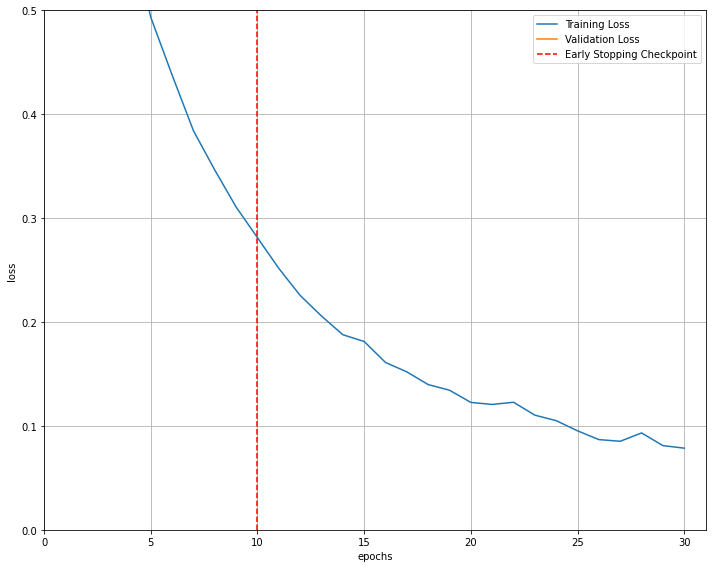

In [29]:
# Visualizing the Loss and the Early Stopping Checkpoint
# From the plot we can see that the last Early Stopping Checkpoint was saved right before the model started to overfit.
# visualize the loss as the network trained
import matplotlib.pyplot as plt
train_loss = avg_train_losses
valid_loss = avg_valid_losses
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

# DENSENET121的方式对CIFAR10进行分类预测

In [ ]:
import torch
from torch import nn, optim
import torchvision
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
%matplotlib inline
import time
show = ToPILImage() #可以把Tensor转换成Image,方便可视化
transform = transforms.Compose([  #transforms.Compose就是将对图像处理的方法集中起来
    transforms.RandomHorizontalFlip(),#水平翻转
    transforms.RandomCrop((32, 32), padding=4),#对图片进行随机裁剪，裁剪的大小是32*32的，填充是4
#     参数：size- (sequence or int)，若为sequence,则为(h,w)，若为int，则(size,size)
#     padding-(sequence or int, optional)，此参数是设置填充多少个pixel。
#     当为int时，图像上下左右均填充int个，例如padding=4，则上下左右均填充4个pixel，若为32x32，则会变成40x40。
#     当为sequence时，若有2个数，则第一个数表示左右扩充多少，第二个数表示上下的。当有4个数时，则为左，上，右，下。
#     fill- (int or tuple) 填充的值是什么（仅当填充模式为constant时有用）。int时，各通道均填充该值，当长度为3的tuple时，表示RGB通道需要填充的值。
    transforms.ToTensor(),#转为Tensor
    #在做数据归一化之前必须要把PIL Image转成Tensor，而其他resize或crop操作则不需要。
     transforms.Normalize((0.5, 0.5 ,0.5), (0.5, 0.5, 0.5)),#归一化
#     归一化操作，这里有两个参数一个是均值，一个是方差，由于是RGB型的所以一个参有三个值，这里面的参数的大小是可调的，调节的公式是：
#     class torchvision.transforms.Normalize(mean, std)，
#     Normalized_image=(image-mean)/std
#     channel=（channel-mean）/std(因为transforms.ToTensor()已经把数据处理成[0,1],那么(x-0.5)/0.5
#     就是[-1.0, 1.0])这样一来，我们的数据中的每个值就变成了[-1,1]的数了。
    ])

# 超参数定义
EPOCH = 300               # 训练epoch次数
BATCH_SIZE = 200         # 批训练的数量
LR = 0.0001              # 学习率
DOWNLOAD_MNIST = False  # 设置True 可以自动下载数据

# CIFAR-10数据集下载
train_data = datasets.CIFAR10(root='/content/drive/My Drive/Colab Notebooks/datas/datasets_data',
                         train=True,                         # 训练集
                         # 数据变换(0, 255) -> (0, 1)
                         transform=transform   
                           )

test_data = datasets.CIFAR10(root='/content/drive/My Drive/Colab Notebooks/datas/datasets_data',
                        train=False,                         # 测试集
                        transform=transform
                        #download=True
                          )

# 使用DataLoader进行分批
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

#数据集10个类的定义
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# densenet121 Model
model = torchvision.models.densenet121(pretrained=True)
#损失函数:这里用交叉熵
criterion = nn.CrossEntropyLoss()
#优化器 Adam
optimizer = optim.Adam(model.parameters(), lr=1e-4)

#device : GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

print('Start Training')
# 训练

for epoch in range(EPOCH):
    running_loss = 0.0
    start = time.time()
    for i, data in enumerate(train_loader):#enumerate枚举数据并从下标0开始
        # 读取数据的数据内容和标签
        #print('读取数据的数据内容和标签')
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # 前向传播
        #print('前向传播')
        outputs = model(inputs)
        # 计算损失函数
        #print('计算损失函数')
        loss = criterion(outputs, labels)
        #梯度清零，也就是把loss关于weight的导数变成0.
        optimizer.zero_grad()
        # 反向传播
        loss.backward()
        # 参数更新
        optimizer.step()
        # #打印log信息
        # running_loss += loss.item()# #用于从tensor中获取python数字
        # if i % 2000 == 1999:#每2000个batch打印一次训练状态
        #     print('[%d, %5d] loss: %.3f' \
        #          % (epoch+1, i+1, running_loss / 2000))

        #     running_loss = 0.0
#print('Finished Training')
    end = time.time()
    print('epoch{} loss:{:.4f} using time is {:.2f}s'.format(epoch+1, loss.item(), (end-start)))
    if loss.item() < 0.001:
      print('Training Stop')
      break
print("Finished Traning")


#保存训练模型
torch.save(model, '/content/drive/My Drive/Colab Notebooks/datas/datasets_data/cifar_10_dense121.pt')
model = torch.load('/content/drive/My Drive/Colab Notebooks/datas/datasets_data/cifar_10_dense121.pt')

# 测试
model.eval()
correct = 0
total = 0

for data in test_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    # 前向传播
    out = model(images)
    _, predicted = torch.max(out.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

#输出识别准确率
print('10000测试图像 准确率:{:.4f}%'.format(100 * correct / total)) 

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth



Start Training
epoch1 loss:0.9866 using time is 47.39s
epoch2 loss:0.8631 using time is 47.12s
epoch3 loss:0.5307 using time is 47.25s
epoch4 loss:0.3829 using time is 47.17s
epoch5 loss:0.5108 using time is 47.25s
epoch6 loss:0.3835 using time is 47.23s
epoch7 loss:0.3623 using time is 47.17s
epoch8 loss:0.2443 using time is 47.13s
epoch9 loss:0.3477 using time is 47.11s
epoch10 loss:0.2746 using time is 47.25s
epoch11 loss:0.2666 using time is 47.25s
epoch12 loss:0.2596 using time is 47.31s
epoch13 loss:0.3144 using time is 47.55s
epoch14 loss:0.1757 using time is 47.44s
epoch15 loss:0.1547 using time is 47.34s
epoch16 loss:0.1369 using time is 47.53s
epoch17 loss:0.1344 using time is 47.39s
epoch18 loss:0.1838 using time is 47.03s
epoch19 loss:0.1789 using time is 47.16s
epoch20 loss:0.1635 using time is 47.09s
epoch21 loss:0.1228 using time is 47.00s
epoch22 loss:0.0778 using time is 46.99s
epoch23 loss:0.0753 using time is 47.05s
epoch24 loss:0.1140 using time is 47.00s
epoch25 l

# DENSENET201的方式对CIFAR10进行分类预测(Early Stopping)

In [31]:
import torch
from torch import nn, optim
import torchvision
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from torch.utils.data.sampler import SubsetRandomSampler
import pytorchtools
%matplotlib inline
import time
import numpy as np
show = ToPILImage() #可以把Tensor转换成Image,方便可视化
transform = transforms.Compose([  #transforms.Compose就是将对图像处理的方法集中起来
    transforms.RandomHorizontalFlip(),#水平翻转
    transforms.RandomCrop((32, 32), padding=4),#对图片进行随机裁剪，裁剪的大小是32*32的，填充是4
#     参数：size- (sequence or int)，若为sequence,则为(h,w)，若为int，则(size,size)
#     padding-(sequence or int, optional)，此参数是设置填充多少个pixel。
#     当为int时，图像上下左右均填充int个，例如padding=4，则上下左右均填充4个pixel，若为32x32，则会变成40x40。
#     当为sequence时，若有2个数，则第一个数表示左右扩充多少，第二个数表示上下的。当有4个数时，则为左，上，右，下。
#     fill- (int or tuple) 填充的值是什么（仅当填充模式为constant时有用）。int时，各通道均填充该值，当长度为3的tuple时，表示RGB通道需要填充的值。
    transforms.ToTensor(),#转为Tensor
    #在做数据归一化之前必须要把PIL Image转成Tensor，而其他resize或crop操作则不需要。
     transforms.Normalize((0.5, 0.5 ,0.5), (0.5, 0.5, 0.5)),#归一化
#     归一化操作，这里有两个参数一个是均值，一个是方差，由于是RGB型的所以一个参有三个值，这里面的参数的大小是可调的，调节的公式是：
#     class torchvision.transforms.Normalize(mean, std)，
#     Normalized_image=(image-mean)/std
#     channel=（channel-mean）/std(因为transforms.ToTensor()已经把数据处理成[0,1],那么(x-0.5)/0.5
#     就是[-1.0, 1.0])这样一来，我们的数据中的每个值就变成了[-1,1]的数了。
    ])

# CIFAR-10数据集下载
train_data = datasets.CIFAR10(root='/content/drive/My Drive/Colab Notebooks/datas/datasets_data',
                         train=True,                         # 训练集
                         # 数据变换(0, 255) -> (0, 1)
                         transform=transform   
                           )

test_data = datasets.CIFAR10(root='/content/drive/My Drive/Colab Notebooks/datas/datasets_data',
                        train=False,                         # 测试集
                        transform=transform
                        #download=True
                          )

#划分训练集用于生成验证集
valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

#定义用于获取训练和验证批次的采样器
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# 使用DataLoader进行分批
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=0)
valid_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, sampler=valid_sampler, num_workers=0)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE)

#数据集10个类的定义
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# from pytorchtools import EarlyStopping
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')	# 这里会存储迄今最优模型的参数
        self.val_loss_min = val_loss

# densenet201 Model
model = torchvision.models.densenet201(pretrained=True)

batch_size = 256
n_epochs = 200

# early stopping patience; how long to wait after last time validation loss improved.
patience = 20
    
#损失函数:这里用交叉熵
criterion = nn.CrossEntropyLoss()
#优化器 Adam
optimizer = optim.Adam(model.parameters(), lr=1e-4)

#device : GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# to track the training loss as the model trains
train_losses = []
# to track the validation loss as the model trains
valid_losses = []
# to track the average training loss per epoch as the model trains
avg_train_losses = []
# to track the average validation loss per epoch as the model trains
avg_valid_losses = [] 

# initialize the early_stopping object
early_stopping = EarlyStopping(patience=patience, verbose=True)

for epoch in range(1, n_epochs + 1):

    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    start = time.time()
    # for batch, (data, target) in enumerate(train_loader, 1):
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # 前向传播
        #print('前向传播')
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(inputs)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # calculate the loss
        loss = criterion(outputs, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # record training loss
        train_losses.append(loss.item())

    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    # for data, target in valid_loader:
    for i, data in enumerate(valid_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(inputs)
        # calculate the loss
        loss = criterion(output, labels)
        # record validation loss
        valid_losses.append(loss.item())

    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)
    
    epoch_len = len(str(n_epochs))
    
    print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                  f'train_loss: {train_loss:.5f} ' +
                  f'valid_loss: {valid_loss:.5f}')
    
    print(print_msg)
    print('using time is :{}'.format(time.time()-start))
    # clear lists to track next epoch
    train_losses = []
    valid_losses = []
    
    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(valid_loss, model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break
    
# load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pt'))



# model, train_loss, valid_loss = train_model(model, batch_size, patience, n_epochs) 

#保存训练模型
torch.save(model, '/content/drive/My Drive/Colab Notebooks/datas/datasets_data/cifar_10_resnet101.pt')
model = torch.load('/content/drive/My Drive/Colab Notebooks/datas/datasets_data/cifar_10_resnet101.pt')

# 测试
model.eval()
correct = 0
total = 0

for data in test_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    # 前向传播
    out = model(images)
    _, predicted = torch.max(out.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

#输出识别准确率
print('10000测试图像 准确率:{:.4f}%'.format(100 * correct / total)) 

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth



[  1/200] train_loss: 2.38359 valid_loss: 0.93257
using time is :59.490923166275024
Validation loss decreased (inf --> 0.932568).  Saving model ...
[  2/200] train_loss: 0.80062 valid_loss: 0.74390
using time is :59.6456081867218
Validation loss decreased (0.932568 --> 0.743898).  Saving model ...
[  3/200] train_loss: 0.61809 valid_loss: 0.63135
using time is :59.81680417060852
Validation loss decreased (0.743898 --> 0.631350).  Saving model ...
[  4/200] train_loss: 0.51543 valid_loss: 0.56782
using time is :59.77269244194031
Validation loss decreased (0.631350 --> 0.567822).  Saving model ...
[  5/200] train_loss: 0.42959 valid_loss: 0.55006
using time is :59.615387201309204
Validation loss decreased (0.567822 --> 0.550058).  Saving model ...
[  6/200] train_loss: 0.36364 valid_loss: 0.55732
using time is :59.785096645355225
EarlyStopping counter: 1 out of 20
[  7/200] train_loss: 0.30178 valid_loss: 0.52587
using time is :59.52797842025757
Validation loss decreased (0.550058 --> 0

# DenseNet201 lr 0.0001

In [ ]:
import torch
from torch import nn, optim
import torchvision
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
%matplotlib inline
import time
show = ToPILImage() #可以把Tensor转换成Image,方便可视化
transform = transforms.Compose([  #transforms.Compose就是将对图像处理的方法集中起来
    transforms.RandomHorizontalFlip(),#水平翻转
    transforms.RandomCrop((32, 32), padding=4),#对图片进行随机裁剪，裁剪的大小是32*32的，填充是4
#     参数：size- (sequence or int)，若为sequence,则为(h,w)，若为int，则(size,size)
#     padding-(sequence or int, optional)，此参数是设置填充多少个pixel。
#     当为int时，图像上下左右均填充int个，例如padding=4，则上下左右均填充4个pixel，若为32x32，则会变成40x40。
#     当为sequence时，若有2个数，则第一个数表示左右扩充多少，第二个数表示上下的。当有4个数时，则为左，上，右，下。
#     fill- (int or tuple) 填充的值是什么（仅当填充模式为constant时有用）。int时，各通道均填充该值，当长度为3的tuple时，表示RGB通道需要填充的值。
    transforms.ToTensor(),#转为Tensor
    #在做数据归一化之前必须要把PIL Image转成Tensor，而其他resize或crop操作则不需要。
     transforms.Normalize((0.5, 0.5 ,0.5), (0.5, 0.5, 0.5)),#归一化
#     归一化操作，这里有两个参数一个是均值，一个是方差，由于是RGB型的所以一个参有三个值，这里面的参数的大小是可调的，调节的公式是：
#     class torchvision.transforms.Normalize(mean, std)，
#     Normalized_image=(image-mean)/std
#     channel=（channel-mean）/std(因为transforms.ToTensor()已经把数据处理成[0,1],那么(x-0.5)/0.5
#     就是[-1.0, 1.0])这样一来，我们的数据中的每个值就变成了[-1,1]的数了。
    ])

# 超参数定义
EPOCH = 100               # 训练epoch次数
BATCH_SIZE = 200         # 批训练的数量
LR = 0.0001              # 学习率
DOWNLOAD_MNIST = False  # 设置True 可以自动下载数据

# CIFAR-10数据集下载
train_data = datasets.CIFAR10(root='/content/drive/My Drive/Colab Notebooks/datas/datasets_data',
                         train=True,                         # 训练集
                         # 数据变换(0, 255) -> (0, 1)
                         transform=transform   
                           )

test_data = datasets.CIFAR10(root='/content/drive/My Drive/Colab Notebooks/datas/datasets_data',
                        train=False,                         # 测试集
                        transform=transform
                        #download=True
                          )

# 使用DataLoader进行分批
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

#数据集10个类的定义
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# densenet201 Model
model = torchvision.models.densenet201(pretrained=True)
#损失函数:这里用交叉熵
criterion = nn.CrossEntropyLoss()
#优化器 Adam
optimizer = optim.Adam(model.parameters(), lr=1e-4)

#device : GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

print('Start Training')
# 训练

for epoch in range(EPOCH):
    running_loss = 0.0
    start = time.time()
    for i, data in enumerate(train_loader):#enumerate枚举数据并从下标0开始
        # 读取数据的数据内容和标签
        #print('读取数据的数据内容和标签')
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # 前向传播
        #print('前向传播')
        outputs = model(inputs)
        # 计算损失函数
        #print('计算损失函数')
        loss = criterion(outputs, labels)
        #梯度清零，也就是把loss关于weight的导数变成0.
        optimizer.zero_grad()
        # 反向传播
        loss.backward()
        # 参数更新
        optimizer.step()
        # #打印log信息
        # running_loss += loss.item()# #用于从tensor中获取python数字
        # if i % 2000 == 1999:#每2000个batch打印一次训练状态
        #     print('[%d, %5d] loss: %.3f' \
        #          % (epoch+1, i+1, running_loss / 2000))

        #     running_loss = 0.0
#print('Finished Training')
    end = time.time()
    print('epoch{} loss:{:.4f} using time is {:.2f}s'.format(epoch+1, loss.item(), (end-start)))
    if loss.item() < 0.05:
      print('Training Stop')
      break
print("Finished Traning")


#保存训练模型
torch.save(model, '/content/drive/My Drive/Colab Notebooks/datas/datasets_data/cifar_10_dense201.pt')
model = torch.load('/content/drive/My Drive/Colab Notebooks/datas/datasets_data/cifar_10_dense201.pt')

# 测试
model.eval()
correct = 0
total = 0

for data in test_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    # 前向传播
    out = model(images)
    _, predicted = torch.max(out.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

#输出识别准确率
print('10000测试图像 准确率:{:.4f}%'.format(100 * correct / total)) 

Start Training
epoch1 loss:0.9641 using time is 142.08s
epoch2 loss:0.6992 using time is 142.10s
epoch3 loss:0.5758 using time is 142.06s
epoch4 loss:0.4800 using time is 142.11s
epoch5 loss:0.4798 using time is 140.64s
epoch6 loss:0.2209 using time is 140.59s
epoch7 loss:0.3321 using time is 140.28s
epoch8 loss:0.2763 using time is 141.65s
epoch9 loss:0.1889 using time is 142.06s
epoch10 loss:0.1396 using time is 142.42s
epoch11 loss:0.1139 using time is 142.27s
epoch12 loss:0.1575 using time is 142.29s
epoch13 loss:0.2051 using time is 141.63s
epoch14 loss:0.0781 using time is 141.93s
epoch15 loss:0.0959 using time is 142.19s
epoch16 loss:0.0855 using time is 141.87s
epoch17 loss:0.0961 using time is 142.04s
epoch18 loss:0.1600 using time is 142.10s
epoch19 loss:0.0747 using time is 141.78s
epoch20 loss:0.1118 using time is 141.96s
epoch21 loss:0.0672 using time is 142.21s
epoch22 loss:0.0543 using time is 142.57s
epoch23 loss:0.0690 using time is 142.37s
epoch24 loss:0.0354 using ti